In [ ]:
import theano
import theano.tensor as T
import lasagne
import h5py
import numpy as np
import sys

sys.path.append("..")
from networks import  residual_unet, residual_unet_old, debug_net

In [ ]:
# DATASET = '/home/sebastianschlecht/depth_data/nyu_v1_shuffled'
DATASET = '/home/sebastianschlecht/depth_data/nyu_depth_v2_resized'
model = '../data/resunet_epoch_20.npz'
f = h5py.File(DATASET + ".hdf5")
length = f["images"].shape[0]
images = np.array(f["images"][0:100]).astype(np.float32)
images_orig = images.copy()
depths = np.array(f["depths"][0:100]).astype(np.float32)
m = np.load(DATASET + ".npy").astype(np.float32)
for i in range(images.shape[0]):
    images[i] = (images[i] - m) / 70.
    

input_var = T.tensor4('inputs')
network = residual_unet_old(input_var=input_var)
# Downsample factor
ds = 2
prediction = lasagne.layers.get_output(network, deterministic=True)

if model is not None:
    print "Loading model weights %s" % model
    with np.load(model) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(network, param_values)
fn = theano.function([input_var], prediction)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
mm = []
ds = 2
for idx in range(16,32):
    sample = images[idx,:,9:9+240, 12:12+320].astype(np.float32)
    r = fn(sample.reshape((-1,3,240,320)))
    #r = np.exp(r)
    if idx % 1 == 0:
        plt.imshow(images_orig[idx].astype(np.uint8).transpose((1,2,0)))
        plt.show()
        plt.imshow(depths[idx,::ds,::ds])
        plt.show()
        plt.imshow(r[0].squeeze())
        plt.show()
    m = ((depths[idx,9:9+240:ds, 12:12+320:ds]) - (r.squeeze())) ** 2
    mm.append(m)
print np.array(mm).mean()


In [4]:
import numpy
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """ 
     
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
        

    if window_len<3:
        return x
    
    
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
    

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')
    
    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y    

0.582411392292


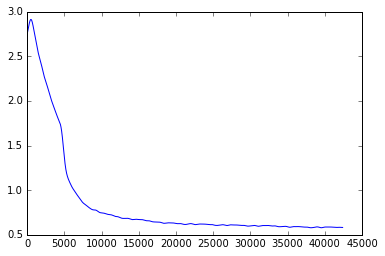

In [119]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

d = np.load("../data/resunet_epoch_20_loss_train.npy")
print d[-5]
plt.plot(smooth(d, window_len=1000))
plt.show()



In [ ]:
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.append("..")
from main import start_prefetching_thread, iterate_minibatches_synchronized

start_prefetching_thread((16, True))
for e in range(10):
    for batch in iterate_minibatches_synchronized(16,16,augment=True):
        inp,t = batch
        for idx in range(10,11):
            print inp[idx].mean()
            print t.mean()
            plt.imshow((inp[idx] * 70.).astype(np.uint8).transpose((1,2,0)))
            plt.show()
            plt.imshow(t[idx])
            plt.show()
            print idx